# GitOps Flow with MLRun

## Setup Project

In [2]:
import os

from src import create_and_set_project, load_config, TrainConfig, EvaluateConfig, DeployConfig

config = load_config()

project = create_and_set_project(name=config.project_name, git_source=config.local_source)

> 2023-09-19 00:17:47,366 [info] Project loaded successfully: {'project_name': 'cicd-flow'}
Exporting project as zip archive to v3io:///bigdata/cicd-flow.zip...


## Run Training Pipeline

In [2]:
train_config = TrainConfig(**config)

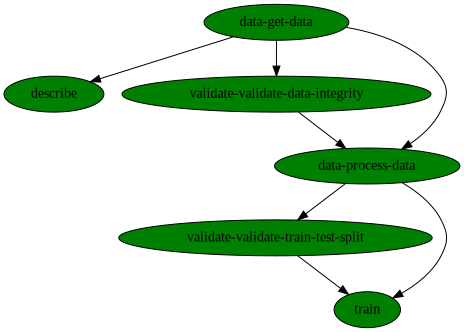

uid,start,state,name,parameters,results
...f27e8d57,Sep 18 23:43:07,completed,train,label_column=target,best_iteration=4accuracy=0.896551724137931f1_score=0.888888888888889precision_score=0.8recall_score=1.0
...6bd5b1cb,Sep 18 23:42:29,completed,validate-validate-train-test-split,label_column=targetallow_validation_failure=True,passed_suite=False
...1067dd91,Sep 18 23:42:03,completed,data-process-data,"label_column=targettest_size=0.1ohe_columns=['sex', 'cp', 'slope', 'thal', 'restecg']",
...411f84c7,Sep 18 23:41:03,completed,validate-validate-data-integrity,label_column=targetallow_validation_failure=True,passed_suite=True
...f016dd3c,Sep 18 23:41:03,completed,describe,label_column=target,
...29569f9d,Sep 18 23:40:36,completed,data-get-data,,


In [3]:
run_id = project.run(
    name="train",
    arguments=train_config.dict(),
    dirty=True,
    watch=True
)

## Run Evaluation Pipeline

In [14]:
# model_path = project.list_models(name=config.model_name, tag="latest", best_iteration=True)[0].uri
# train_set = project.get_artifact("data-process-data_train").uri
# test_set = project.get_artifact("data-process-data_test").uri

evaluate_config = EvaluateConfig(**config.dict())    

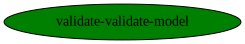

uid,start,state,name,parameters,results
...2f2b1a4b,Sep 18 23:47:09,completed,validate-validate-model,model_path=store://models/cicd-flow/model#4:4c054e48-2d96-4cd8-8494-7855594c816blabel_column=targetallow_validation_failure=True,passed_suite=False


In [16]:
run_id = project.run(
    name="evaluate",
    arguments=evaluate_config.dict(),
    dirty=True,
    watch=True
)

## Run Deployment Pipeline

In [16]:
deploy_config = DeployConfig(**config.dict())

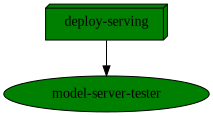

uid,start,state,name,parameters,results
...28871ed7,Sep 18 23:52:16,completed,model-server-tester,addr=http://cicd-flow-serving-cicd-flow.default-tenant.app.us-tmp-353.iguazio-cd2.com/label_column=targetmodel=model,total_tests=20errors=0match=5avg_latency=123072min_latency=119726max_latency=131155


In [22]:
run_id = project.run(
    name="deploy",
    arguments=deploy_config.dict(),
    dirty=True,
    watch=True
)

### Invoke Model

In [27]:
# Get serving function
serving_fn = project.get_function("serving")
model_name = config["model_name"]
label_column = config["label_column"]

# Get test set
df = project.get_artifact("data-process-data_test").to_dataitem().as_df()
display(df.head())

# Transform to list
# Get training set as list
data = df.drop(label_column, axis=1).to_dict(orient="split")["data"]
# data
serving_fn.invoke(
    f"v2/models/{model_name}/infer", json.dumps({"inputs": data[:5]})
)

,sex_female,sex_male,cp_asymtomatic,cp_atypical_angina,cp_non_anginal_pain,cp_typical_angina,slope_downsloping,slope_flat,slope_upsloping,thal_fixed_defect,...,restecg_st-t_wave_abnormality,age,exang,fbs,trestbps,chol,thalach,oldpeak,ca,target
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,54.0,1.0,0.0,122.0,286.0,116.0,3.2,2.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,58.0,1.0,0.0,128.0,216.0,131.0,2.2,3.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,54.0,0.0,0.0,150.0,232.0,165.0,1.6,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,60.0,1.0,0.0,130.0,206.0,132.0,2.4,2.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,62.0,0.0,0.0,124.0,209.0,163.0,0.0,0.0,1.0


> 2023-09-18 23:55:07,184 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-cicd-flow-serving.default-tenant.svc.cluster.local:8080/v2/models/model/infer'}


{'id': '77b7af43-be32-4f41-be5b-7ef49d772cdd',
 'model_name': 'model',
 'outputs': [0.0, 0.0, 1.0, 0.0, 1.0]}

### Simulate Traffic

MLRun real-time drift detection requires 10,000 events

In [ ]:
import json
import logging
from random import choice

from tqdm.notebook import tqdm

# Suppress print messages
logging.getLogger(name="mlrun").setLevel(logging.WARNING)

# Simulate traffic using random elements from training set
for i in tqdm(range(12_000)):
    data_point = choice(data)
    serving_fn.invoke(
        f"v2/models/{model_name}/infer", json.dumps({"inputs": [data_point]})
    )

# Resume normal logging
logging.getLogger(name="mlrun").setLevel(logging.INFO)